# Baseline model for multiclass classification
Predict the rating based on title's length, comment's length, number of days between the transaction date and date of review

## Required librairies

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

from time import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics

# import python script with customised plotting functions
from plot_metrics import plot_metrics_and_time, plot_radar_metrics, plot_radar_mult
from plot_metrics import plot_radar_some, barplot_metric_mult, stack_barplot, lineplot_metrics

## Load reviews data

In [2]:
df = pd.read_csv("redoute_v3.csv", index_col = 0).reset_index().drop("id", axis = 1)
df.head(1)

,rating,title,comment,createdAt,transaction,SupplierReply,SupplierReplyDate,date_of_cmt,year_of_cmt,month_of_cmt,...,year_of_transaction,month_of_transaction,day_of_transaction,weekday_of_transaction,transaction_in_weekend,transaction_date,comment_length,log_comment_length,title_length,nb_days_before_review
0,4,Facilte,"Facilte, sollicitations dosées...qualité..on p...",2023-10-05 14:18:42,2023-09-23,NaN,NaN,2023-10-05,2023,10,...,2023,9,23,5,1,2023-09-23,1049,6.955593,7,12.0


In [3]:
# Prepare the data for a classification model to predicts the rating from comment_lenght, title_length and nb_days_before_review
features = df[["comment_length", "title_length", "nb_days_before_review"]]
#data.head()

# A rating is called a positive rating if it is > 3 we then set sentiment_rmc = 1
# A rating is called a neutral rating if it is 3 we then set sentiment_rmc = 0
# A rating is called a negative rating if it is < 3 we then set sentiment_rmc = 1
target = -1*(df["rating"]<3) + 1*(df["rating"]>3) 
df["sentiment_rmc"] = target


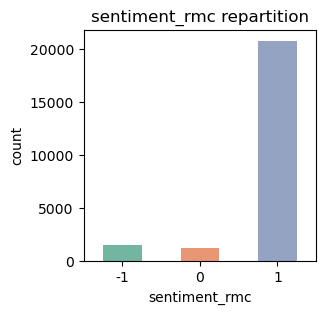

In [4]:
plt.figure(figsize=(3,3))
sns.countplot(data=df, x="sentiment_rmc", width=0.5, palette = "Set2")
plt.title("sentiment_rmc repartition")
plt.show()

## Train, test and split

Binary classification with sentiment_r as target

In [5]:
# Split data into train data and test data with test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, stratify = target, random_state = 23)


## Preprocessing
- Random Undersampling to tackle imabalance in the classes
- Standard scaling
- MinMax scaling

In [6]:
def scale_data(Xtr,Xts, ytr, scaler="standard"):
    """Scaling of features and Random under sampling on train data 
       with  StandScaler if scaler ="standard", MinMaxScaler if scaler = "minmax"
    """

    if scaler=="standard":
        #standard scaling
        scaler = StandardScaler()
        Xtr_scaled = scaler.fit_transform(Xtr)
        Xts_scaled = scaler.transform(Xts)
        
    elif scaler =="minmax":
        scaler = MinMaxScaler()
        Xtr_scaled = scaler.fit_transform(Xtr)
        Xts_scaled = scaler.transform(Xts)
        
    else:
        raise ValueError("scaler must be strings: 'standard' or 'minmax'")

    #random undersampling
    ru = RandomUnderSampler()
    (X_ru, y_ru) = ru.fit_resample(Xtr_scaled, ytr)
    
    return Xtr_scaled, Xts_scaled, X_ru, y_ru

#Standard scaled data
X_train_s, X_test_s, X_ru_s, y_ru_s = scale_data(X_train, X_test, y_train)

# With MinMax scaled data
X_train_m, X_test_m, X_ru_m, y_ru_m = scale_data(X_train, X_test, y_train, "minmax")


#control
#print(X_train_s.mean(), X_train_s.std(), X_test_s.mean(), X_test_s.std())
#print(X_train_m.min(), X_train_m.max(), X_test_m.min(), X_test_m.max())


##  Multiclass Classification
The objective is to predict wether the rating is positive (1) or negative (0)
- Positive rating: rating > 3
- Neutral Rating: rating == 3
- Negative rating: rating < 3

###  Function to train and evaluate the model

In [7]:
def fit_and_evaluate(model_name, model, Xru, yru, Xtest, ytest):
    """ function to fit a model and calculate its metrics and time performance
        return a DataFrame of model metrics, model time performance, confusion matrix
        and classification report
    """
    # Fit the model to the training random undersampled data
    t0 = time()
    model.fit(Xru, yru)
    t1 = time()

    # Prediction on test data
    prediction = model.predict(Xtest) 
    t2 = time()
    
    # get durations of processes
    time_train = t1-t0
    time_predict = t2-t1

    # get the model metrics
    accuracy = model.score(Xtest, ytest)

    # The balanced accuracy in binary and multiclass classification problems 
    # to deal with imbalanced datasets.
    # It is defined as the average of recall obtained on each class.
    # The best value is 1 and the worst value is 0 when adjusted=False.
    balanced_accuracy = metrics.balanced_accuracy_score(ytest, prediction)
    
    #f1_score = metrics.f1_score(ytest, prediction)

    # for the recall we set pos_label=0 to track the ability of the model to capture all negatives rating (rating <=3)
    #recall = metrics.recall_score(ytest, prediction)
    recall_macro = metrics.recall_score(ytest, prediction, average="macro")
    recall_weighted = metrics.recall_score(ytest, prediction, average="weighted")

    f1_score_macro = metrics.f1_score(ytest, prediction, average="macro")
    f1_score_weighted = metrics.f1_score(ytest, prediction, average="weighted")
    
    # precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
    # we set pos_label=0
    #precision = metrics.precision_score(ytest, prediction)
    precision_macro = metrics.precision_score(ytest, prediction, average="macro" )
    precision_weighted = metrics.precision_score(ytest, prediction, average="weighted")
    
    cl_report = metrics.classification_report(ytest, prediction)
    cf_matrix = pd.crosstab(ytest, prediction, rownames = ["Real"], colnames=["Prediction"])
    
    # time and metrics
    res = {"model": model_name, 
           "accuracy": accuracy, "balanced_accuracy": balanced_accuracy, 
           #"f1": f1_score, 
           "f1_macro": f1_score_macro, "f1_weighted": f1_score_weighted,
           #"recall_0": recall, 
           "recall_macro": recall_macro, "recall_weighted": recall_weighted,
           #"precision_0" : precision, 
           "precision_macro" : precision_macro, "precision_weighted" : precision_weighted,
           "time_train":time_train, "time_predict": time_predict}
    
    df_metrics = pd.DataFrame(res, index=[0])

    return (df_metrics, cl_report, cf_matrix)

### Models to test

In [8]:
# Models tested
log_reg = LogisticRegression()
dec_tree = DecisionTreeClassifier()
r_fo = RandomForestClassifier()

lsvc = LinearSVC()
svc = SVC()

m_nb = MultinomialNB()  # ne marche pas si valeurs négatives dans les features
c_nb = ComplementNB()
g_nb = GaussianNB()

knn = KNeighborsClassifier()
gdb = GradientBoostingClassifier()


### Fit and evaluate models

In [9]:
# Logistic regression
log_reg_metrics, log_reg_cl_report, log_reg_cf_matrix = fit_and_evaluate("log_reg", log_reg, 
                                                                         X_ru_s, y_ru_s, 
                                                                         X_test_s, y_test)

In [10]:
# Fit and evaluate models

# Logistic regression
log_reg_metrics, log_reg_cl_report, log_reg_cf_matrix = fit_and_evaluate("log_reg", log_reg, 
                                                                         X_ru_s, y_ru_s, 
                                                                         X_test_s, y_test)

# Decision Tree
dec_tree_metrics, dec_tree_cl_report, dec_tree_cf_matrix = fit_and_evaluate("dec_tree", dec_tree, 
                                                                            X_ru_s, y_ru_s, 
                                                                            X_test_s, y_test)

# Random forest  on standard scaled data
r_fo_metrics, r_fo_cl_report, r_fo_cf_matrix = fit_and_evaluate("r_fo", r_fo, 
                                                                X_ru_s, y_ru_s, 
                                                                X_test_s, y_test)

# Gaussian NB
g_nb_metrics, g_nb_cl_report, g_nb_cf_matrix = fit_and_evaluate("g_nb", g_nb, 
                                                                X_ru_s, y_ru_s, 
                                                                X_test_s, y_test)

# Multinomial NB on minmax scaled data
m_nb_metrics, m_nb_cl_report, m_nb_cf_matrix = fit_and_evaluate("m_nb", m_nb, 
                                                                X_ru_m, y_ru_m, 
                                                                X_test_m, y_test)

# Complement NB on minmax scaled data
c_nb_metrics, c_nb_cl_report, c_nb_cf_matrix = fit_and_evaluate("c_nb", c_nb, 
                                                                X_ru_m, y_ru_m, 
                                                                X_test_m, y_test)

#Linear SVC
lsvc_metrics, lsvc_cl_report, lsvc_cf_matrix = fit_and_evaluate("lsvc", lsvc, 
                                                                X_ru_s, y_ru_s, 
                                                                X_test_s, y_test)

# SVM
svc_metrics, svc_cl_report, svc_cf_matrix = fit_and_evaluate("svc", svc, 
                                                             X_ru_s, y_ru_s, 
                                                             X_test_s, y_test)

# KNeighborsClassifier
knn_metrics, knn_cl_report, knn_cf_matrix = fit_and_evaluate("knn", knn, 
                                                             X_ru_s, y_ru_s, 
                                                             X_test_s, y_test)

# Gradient Boosting
gdb_metrics, gdb_cl_report, gdb_cf_matrix = fit_and_evaluate("gdb", gdb, 
                                                             X_ru_s, y_ru_s, 
                                                             X_test_s, y_test)


## Visualize and compare models performance

### Prepare and save data for visualization

In [11]:
# Put all the models metrics in list
metrics_list = [log_reg_metrics, dec_tree_metrics, r_fo_metrics, 
                g_nb_metrics, m_nb_metrics, c_nb_metrics, 
                lsvc_metrics, svc_metrics,  
                knn_metrics, gdb_metrics]

# concat models metrics into a single data frame
df_m = pd.concat(metrics_list).reset_index().drop("index", axis=1)

# Save metrics into a csv_file
df_temp=df_m.copy()

# add _bsl to model's name to signal a baseline model performance
df_temp["model"] = df_temp["model"]+"_bsl"
df_temp.to_csv("baseline_mcl_perf.csv")
del df_temp

### Datavisualization

In [12]:
# Comparison of metrics scores
data = df_m.iloc[:,:-2]  # to skip time_train and time_predict
plot_radar_mult(data)

In [13]:
# Line plots of metrics for comparison
lineplot_metrics(data)

In [14]:
# train performance
barplot_metric_mult(df_m, "time_train")
barplot_metric_mult(df_m, "time_predict")

In [15]:
# Comparaison of Accuracy, recall_macro, precision_macro, recall_0, precision_0
for metric in ["accuracy", "recall_macro", "precision_macro"]:
    barplot_metric_mult(data, metric)

In [16]:
# Compare time_train and time_prodict 
stack_barplot(df_m, "time_train", "time_predict")

In [17]:
# Compare recall_macro and precision_macro
stack_barplot(df_m, "recall_macro", "precision_macro")

### Remarks
The precision for label 0 (negative ratings: 1, 2,3 ) for all the models is low with a value between 0.19 and 0.34. At least two third of predicted negatives rating are in fact positive ratings. That is two third of false positives.

The models f1_macro are all superior 0.5 and over 0.6 for the best performing ones.

The best performing model with respect to precision and recall for negative rating, f1-macro and recall macro are :
- - Logistric Regression
  - LinearSVC
  - SGaussianNB
  -





In [18]:
# Display Classification reports and Confusion Matrix

print("********** log reg **********")
print(log_reg_cl_report)
display(log_reg_cf_matrix)

print("********** Dec Tree **********")
print(dec_tree_cl_report)
display(dec_tree_cf_matrix)

print("********** Random Forest **********")
print(r_fo_cl_report)
display(r_fo_cf_matrix)

print("********** G NB **********")
print( g_nb_cl_report)
display( g_nb_cf_matrix)

print("********** Multinomial NB **********")
print(m_nb_cl_report)
display(m_nb_cf_matrix)

print("********** Complement NB **********")
print(c_nb_cl_report)
display(c_nb_cf_matrix)

print("********** LinearSVC **********")
print(lsvc_cl_report)
display(lsvc_cf_matrix)

print("********** SVC **********")
print(svc_cl_report)
display(svc_cf_matrix)

print("********** KNN **********")
print(knn_cl_report)
display(knn_cf_matrix)

print("********** Gradient Boost **********")
print(gdb_cl_report)
display(gdb_cf_matrix)


********** log reg **********
              precision    recall  f1-score   support

          -1       0.21      0.41      0.28       368
           0       0.13      0.33      0.18       307
           1       0.95      0.80      0.87      5193

    accuracy                           0.75      5868
   macro avg       0.43      0.51      0.44      5868
weighted avg       0.86      0.75      0.79      5868



Prediction,-1,0,1
Real,,,
-1,150,109,109
0,93,101,113
1,470,594,4129


********** Dec Tree **********
              precision    recall  f1-score   support

          -1       0.10      0.40      0.16       368
           0       0.08      0.37      0.13       307
           1       0.94      0.53      0.68      5193

    accuracy                           0.51      5868
   macro avg       0.37      0.43      0.32      5868
weighted avg       0.85      0.51      0.61      5868



Prediction,-1,0,1
Real,,,
-1,146,135,87
0,115,115,77
1,1212,1246,2735


********** Random Forest **********
              precision    recall  f1-score   support

          -1       0.12      0.44      0.19       368
           0       0.08      0.34      0.13       307
           1       0.96      0.60      0.74      5193

    accuracy                           0.58      5868
   macro avg       0.39      0.46      0.35      5868
weighted avg       0.86      0.58      0.67      5868



Prediction,-1,0,1
Real,,,
-1,161,134,73
0,130,105,72
1,1004,1066,3123


********** G NB **********
              precision    recall  f1-score   support

          -1       0.21      0.36      0.26       368
           0       0.14      0.19      0.16       307
           1       0.93      0.87      0.90      5193

    accuracy                           0.80      5868
   macro avg       0.43      0.47      0.44      5868
weighted avg       0.84      0.80      0.82      5868



Prediction,-1,0,1
Real,,,
-1,131,74,163
0,81,58,168
1,424,276,4493


********** Multinomial NB **********
              precision    recall  f1-score   support

          -1       0.12      0.33      0.18       368
           0       0.09      0.28      0.14       307
           1       0.93      0.71      0.80      5193

    accuracy                           0.66      5868
   macro avg       0.38      0.44      0.37      5868
weighted avg       0.84      0.66      0.73      5868



Prediction,-1,0,1
Real,,,
-1,123,98,147
0,93,86,128
1,776,755,3662


********** Complement NB **********
              precision    recall  f1-score   support

          -1       0.12      0.39      0.19       368
           0       0.09      0.17      0.12       307
           1       0.93      0.73      0.82      5193

    accuracy                           0.68      5868
   macro avg       0.38      0.43      0.37      5868
weighted avg       0.83      0.68      0.74      5868



Prediction,-1,0,1
Real,,,
-1,145,64,159
0,108,51,148
1,924,457,3812


********** LinearSVC **********
              precision    recall  f1-score   support

          -1       0.22      0.46      0.30       368
           0       0.13      0.21      0.16       307
           1       0.94      0.84      0.89      5193

    accuracy                           0.78      5868
   macro avg       0.43      0.50      0.45      5868
weighted avg       0.86      0.78      0.81      5868



Prediction,-1,0,1
Real,,,
-1,170,76,122
0,109,63,135
1,504,339,4350


********** SVC **********
              precision    recall  f1-score   support

          -1       0.20      0.34      0.25       368
           0       0.12      0.45      0.19       307
           1       0.95      0.75      0.84      5193

    accuracy                           0.71      5868
   macro avg       0.42      0.51      0.43      5868
weighted avg       0.86      0.71      0.77      5868



Prediction,-1,0,1
Real,,,
-1,125,143,100
0,77,137,93
1,414,877,3902


********** KNN **********
              precision    recall  f1-score   support

          -1       0.11      0.50      0.18       368
           0       0.08      0.36      0.14       307
           1       0.95      0.53      0.68      5193

    accuracy                           0.52      5868
   macro avg       0.38      0.46      0.33      5868
weighted avg       0.86      0.52      0.62      5868



Prediction,-1,0,1
Real,,,
-1,183,119,66
0,132,110,65
1,1347,1085,2761


********** Gradient Boost **********
              precision    recall  f1-score   support

          -1       0.18      0.43      0.25       368
           0       0.10      0.38      0.16       307
           1       0.96      0.69      0.80      5193

    accuracy                           0.66      5868
   macro avg       0.41      0.50      0.40      5868
weighted avg       0.86      0.66      0.74      5868



Prediction,-1,0,1
Real,,,
-1,160,123,85
0,114,117,76
1,637,952,3604


##  Optimization with GridSearchCV

,model,accuracy,balanced_accuracy,f1_macro,f1_weighted,recall_macro,recall_weighted,precision_macro,precision_weighted,time_train,time_predict
0,grid_log_reg,0.746421,0.510569,0.441532,0.792641,0.510569,0.746421,0.428326,0.859581,1.034633,0.000459


LogisticRegression(C=1)
{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


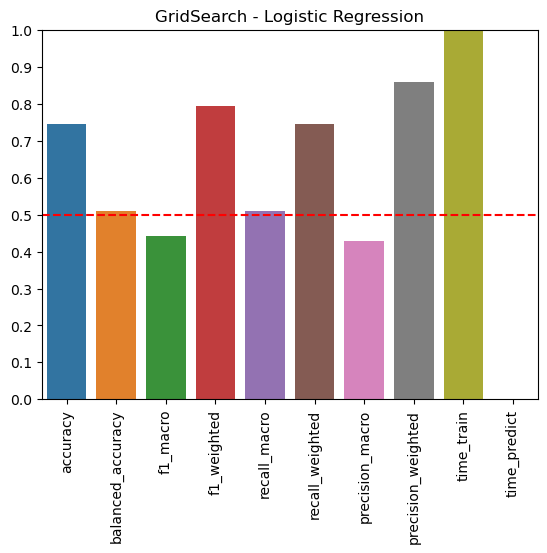

              precision    recall  f1-score   support

          -1       0.21      0.41      0.28       368
           0       0.13      0.33      0.18       307
           1       0.95      0.80      0.87      5193

    accuracy                           0.75      5868
   macro avg       0.43      0.51      0.44      5868
weighted avg       0.86      0.75      0.79      5868



Prediction,-1,0,1
Real,,,
-1,150,109,109
0,93,101,113
1,470,594,4129


In [19]:
# GridSearchCV on LogisticRegression
log_reg = LogisticRegression()

# parameters
params = {"solver": ["lbfgs", "linear", "newton_cg", "sag"], "penalty": ["l2"], "C": [0.001, 0.1, 1, 5, 10, 100]}
#params = {"solver": ["saga"], "penalty": ["elasticnet", "l1", "l2"], "C": [0.001, 0.01, 0.09, 0.1, 0.11, 0.15]}

# GridSearchCV
grid_log_reg = GridSearchCV(estimator=log_reg, param_grid=params, cv=5)

# fit and evaluate
grid_log_reg_metrics, grid_log_reg_cl_report, grid_log_reg_cf_matrix = fit_and_evaluate("grid_log_reg", grid_log_reg, X_ru_s, y_ru_s, X_test_s, y_test)

display(grid_log_reg_metrics)
print(grid_log_reg.best_estimator_)
print(grid_log_reg.best_params_)

# Display metrics
sns.barplot(data=grid_log_reg_metrics.iloc[:,1:])
plt.axhline(y=0.5, linestyle="--", color="red" )
plt.xticks(rotation=90)
plt.yticks(np.linspace(0,1,11))
plt.ylim(0,1)
plt.title("GridSearch - Logistic Regression")
plt.show()
print(grid_log_reg_cl_report)
display(grid_log_reg_cf_matrix)


,model,accuracy,balanced_accuracy,f1_macro,f1_weighted,recall_macro,recall_weighted,precision_macro,precision_weighted,time_train,time_predict
0,grid_lsvc,0.650307,0.508163,0.392361,0.724943,0.508163,0.650307,0.402664,0.862161,2.145461,0.000449


LinearSVC(C=1e-05)
{'C': 1e-05, 'penalty': 'l2'}


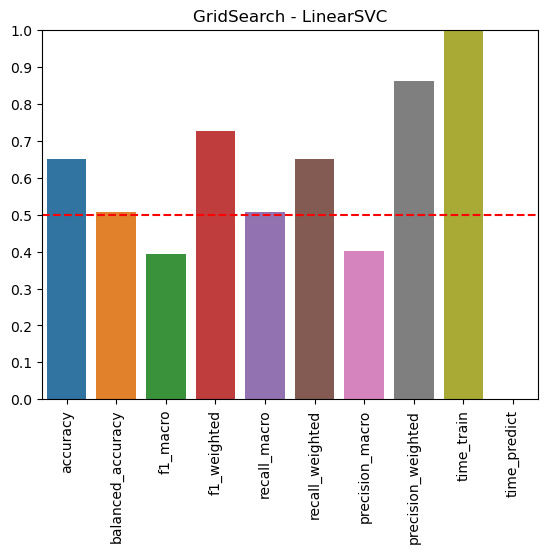

              precision    recall  f1-score   support

          -1       0.16      0.62      0.25       368
           0       0.09      0.22      0.13       307
           1       0.96      0.68      0.79      5193

    accuracy                           0.65      5868
   macro avg       0.40      0.51      0.39      5868
weighted avg       0.86      0.65      0.72      5868



Prediction,-1,0,1
Real,,,
-1,229,54,85
0,167,69,71
1,1034,641,3518


In [20]:
#GridSearchCV on LinearSVC
lsvc = LinearSVC()

# parameters
params = {"penalty": ["l2"], "C": [1e-7, 1e-6, 1e-5, 1e-4, 0.1, 1]}


# GridSearchCV
grid_lsvc = GridSearchCV(estimator=lsvc, param_grid=params, cv=5)

# fit and evaluate
grid_lsvc_metrics, grid_lsvc_cl_report, grid_lsvc_cf_matrix = fit_and_evaluate("grid_lsvc", grid_lsvc, X_ru_s, y_ru_s, X_test_s, y_test)

display(grid_lsvc_metrics)
print(grid_lsvc.best_estimator_)
print(grid_lsvc.best_params_)

# Display metrics
sns.barplot(data=grid_lsvc_metrics.iloc[:,1:])
plt.axhline(y=0.5, linestyle="--", color="red" )
plt.xticks(rotation=90)
plt.yticks(np.linspace(0,1,11))
plt.ylim(0,1)
plt.title("GridSearch - LinearSVC")
plt.show()
print(grid_lsvc_cl_report)
display(grid_lsvc_cf_matrix)

,model,accuracy,balanced_accuracy,f1_macro,f1_weighted,recall_macro,recall_weighted,precision_macro,precision_weighted,time_train,time_predict
0,grid_svc,0.752556,0.519661,0.449292,0.797224,0.519661,0.752556,0.439643,0.86192,47.424059,0.382031


SVC(C=0.5, kernel='linear')
{'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}


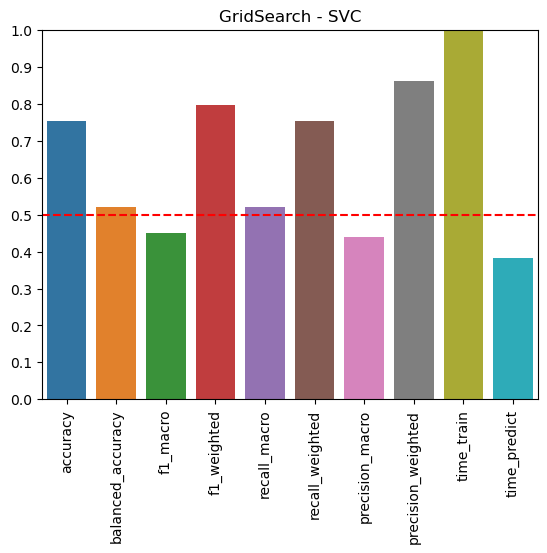

              precision    recall  f1-score   support

          -1       0.23      0.32      0.27       368
           0       0.14      0.44      0.21       307
           1       0.95      0.80      0.87      5193

    accuracy                           0.75      5868
   macro avg       0.44      0.52      0.45      5868
weighted avg       0.86      0.75      0.80      5868



Prediction,-1,0,1
Real,,,
-1,118,139,111
0,62,134,111
1,329,700,4164


In [21]:
#GridSearch SVC

params = {"kernel": ['linear'],
          "C":[0.001, 0.01, 0.5, 1, 10],
          "gamma": ['scale', 'auto', 0.001, 0.02, 0.05, 0.5]}

svc = SVC()

grid_svc = GridSearchCV(estimator=svc, param_grid=params, cv=5)

grid_svc_metrics, grid_svc_cl_report, grid_svc_cf_matrix = fit_and_evaluate("grid_svc", grid_svc, X_ru_s, y_ru_s, X_test_s, y_test)

display(grid_svc_metrics)
print(grid_svc.best_estimator_)
print(grid_svc.best_params_)

# Display metrics
sns.barplot(data=grid_svc_metrics.iloc[:,1:])
plt.axhline(y=0.5, linestyle="--", color="red" )
plt.xticks(rotation=90)
plt.yticks(np.linspace(0,1,11))
plt.ylim(0,1)
plt.title("GridSearch - SVC")
plt.show()
print(grid_svc_cl_report)
display(grid_svc_cf_matrix)

,model,accuracy,balanced_accuracy,f1_macro,f1_weighted,recall_macro,recall_weighted,precision_macro,precision_weighted,time_train,time_predict
0,grid_gdb,0.661384,0.512616,0.408953,0.735675,0.512616,0.661384,0.414676,0.863574,275.528613,0.057366


GradientBoostingClassifier(learning_rate=0.01, max_depth=4)
{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}


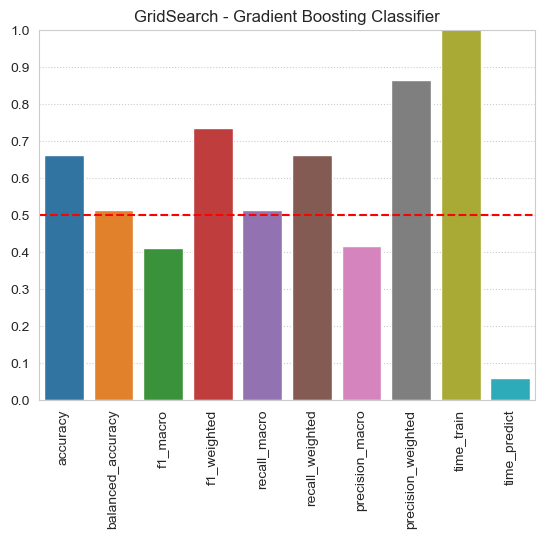

              precision    recall  f1-score   support

          -1       0.19      0.45      0.27       368
           0       0.10      0.40      0.16       307
           1       0.96      0.69      0.80      5193

    accuracy                           0.66      5868
   macro avg       0.41      0.51      0.41      5868
weighted avg       0.86      0.66      0.74      5868



Prediction,-1,0,1
Real,,,
-1,165,116,87
0,109,122,76
1,600,999,3594


In [30]:
# GridSearch - Gradient Boosting

params = {'n_estimators':[100, 150, 200], 'max_depth':[1, 2, 3, 4], 'learning_rate':[ 0.01, 0.1, 1, 10]}

gdb = GradientBoostingClassifier()

grid_gdb = GridSearchCV(estimator=gdb, param_grid=params, cv=5)

grid_gdb_metrics, grid_gdb_cl_report, grid_gdb_cf_matrix = fit_and_evaluate("grid_gdb", grid_gdb, X_ru_s, y_ru_s, X_test_s, y_test)

display(grid_gdb_metrics)
print(grid_gdb.best_estimator_)
print(grid_gdb.best_params_)

# Display metrics
sns.barplot(data=grid_gdb_metrics.iloc[:,1:])
plt.axhline(y=0.5, linestyle="--", color="red" )
plt.xticks(rotation=90)
plt.yticks(np.linspace(0,1,11))
plt.ylim(0,1)
plt.title("GridSearch - Gradient Boosting Classifier")
plt.show()
print(grid_gdb_cl_report)
display(grid_gdb_cf_matrix)

####  Visualization Models versus GridSearchCV results

In [23]:
# Concat gridsearch metrics in a single dataFrame
#grid_metrics_list = [grid_log_reg_metrics, log_reg_metrics, 
                    # grid_lsvc_metrics, lsvc_metrics, 
                    # grid_svc_metrics, svc_metrics,  
                    # grid_gdb_metrics, gdb_metrics]

grid_metrics_list = [grid_log_reg_metrics, 
                     grid_lsvc_metrics, 
                     grid_svc_metrics,  
                     grid_gdb_metrics]

df_grid_m = pd.concat(grid_metrics_list).reset_index().drop("index", axis=1)
df_grid_m

# Save metrics into a csv_file
df_temp=df_grid_m.copy()

# add _bsl_grid to model's name to signal a baseline model performance...
# ... after a GridSearchCV
df_temp["model"] = df_temp["model"]+"_bsl_grid"
df_temp.to_csv("bsl_grid_mcl_perf.csv")
del df_temp

In [25]:
# Visualize and compare models vers GridSearch result
data = df_grid_m.iloc[:,:-2]
plot_radar_mult(data)

# Line plot of models performance
#plot_metrics_and_time(df_grid_m)

KeyError: "['recall_0'] not in index"

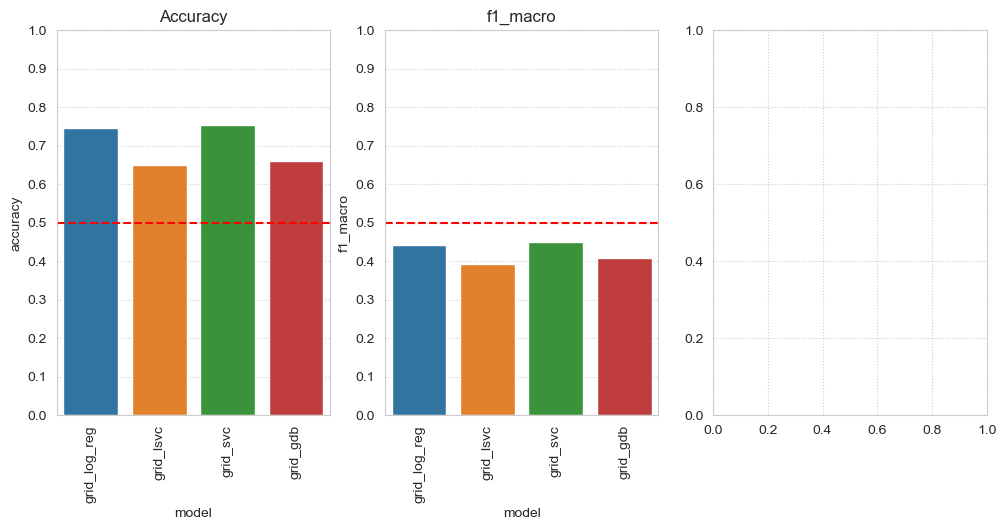

In [26]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
sns.barplot(data = df_grid_m[["model", "accuracy"]], y="accuracy", x="model")
plt.axhline(y=0.5, linestyle="--", color="red")
plt.title("Accuracy")
plt.yticks(np.linspace(0,1,11))
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.barplot(data = df_grid_m[["model", "f1_macro"]], y="f1_macro", x="model")
plt.axhline(y=0.5, linestyle="--", color="red")
plt.title("f1_macro")
plt.yticks(np.linspace(0,1,11))
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.barplot(data = df_grid_m[["model", "recall_0"]], y="recall_0", x="model")
plt.axhline(y=0.5, linestyle="--", color="red")
plt.title("Recall_0")
plt.yticks(np.linspace(0,1,11))
plt.xticks(rotation=90)

plt.show()

In [ ]:
#time_train	time_predict	accuracy	balanced_accuracy	f1	f1_macro	f1_weighted	recall_0	recall_macro	recall_weighted	precision_0	precision_macro	precision_weighted
col_m =["accuracy", "f1_macro", "precision_macro", "recall_0", "precision_0"]
data = df_grid_m.set_index("model")[col_m].T


In [ ]:
#ig = px.bar(df, y='pop', x='country', text_auto='.2s',
#            title="Default: various text sizes, positions and angles")

px.bar(df_grid_m, x = "model", y = "accuracy", text_auto='.2f')

In [ ]:
models = ["log_reg", "lsvc", "svc", "gdb"]
data = df_grid_m.iloc[:,:-2]
plot_radar_mult(data)


### Zoom of some models

In [27]:
data = df_m.iloc[:,:-2]
plot_radar_mult(data)

In [28]:
plot_radar_metrics(log_reg_metrics, "Logistic Regression")
plot_radar_metrics(lsvc_metrics, "LinearSVC")
plot_radar_metrics(gdb_metrics, "Gradient Boost")

In [29]:
data = df_m.set_index("model")[col_m].T
fig = px.line(data, markers=True, title="Models Metrics comparison")
fig.update_yaxes(tick0=0, dtick=0.1)
fig.add_hline(y=0.5, line_dash="dash", line_color="red")
fig.show()

NameError: name 'col_m' is not defined

## Conclusion
- TBD